<a href="https://colab.research.google.com/github/soccer3056/Deep-Learning/blob/master/Trauma_regression_(scikit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl https://course.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   5262      0 --:--:-- --:--:-- --:--:--  5262
Updating fastai...
Done.


In [0]:
!ls /home


In [0]:
import pandas_profiling as pp
import pandas as pd
import numpy as np

from fastai import *
from fastai.tabular import *

In [0]:
# import caffe

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/inference_test2.txt')
np.random.seed(42)

In [0]:
# pp.ProfileReport(df)
test_df = df.head(4)
df = df[4:]

In [0]:
# run only once
test_df = test_df.drop(['penetration', 'trauma', 'v50'], axis=1)


In [0]:
df = df.loc[df['penetration'] != 'X' ]
df = df.drop(['ammunition', 'test_standard', 'v50', 'plate_mat', 'penetration'],axis =1)

df['b_diameter'] = df['b_diameter'].astype(np.float64)
df['b_length'] = df['b_length'].astype(np.float64)

In [0]:
df = df.dropna()
len(df)

3365

In [0]:
int_cols = ['num_shot', 'il_num_layers', 'bc_num_layer']
float_cols = [ 'speed', 'plate_wt', 'thickness', 'ceramic_wt', 'plate_wt_before', 'plate_wt_after', 'il_wt', 'bc_wt', 'glue_wt', 
                'total_thickness', 'total_ad', 'trauma']

# Taking only rows that have numeric num_shot
df = df[df['num_shot'].str.contains('^[0-9]+$', regex= True)]
len(df)

2927

In [0]:
# Convert il_num_layers Xs to 0
df['il_num_layers'].replace(to_replace= "X", value= 0, inplace= True)
df['il_num_layers'].replace(to_replace= "4 + 20", value= 24, inplace= True)
df['il_num_layers'].replace(to_replace= "Aramid (410 gsm)", value= 2, inplace= True)

In [0]:
def try_eval(a):
  try:
    return eval(a)
  except:
    return 8

# bc_num_layer
df['bc_num_layer'].replace(to_replace= "X", value= '0', inplace= True)
df['bc_num_layer'] = df['bc_num_layer'].map(lambda a: try_eval(str(a)))

In [0]:
# speed
df['speed'].replace(to_replace= "X", value= 0.0, inplace= True)
df['speed'].replace(to_replace= "x", value= 0.0, inplace= True)
df['plate_wt'].replace(to_replace= "X", value= 0.0, inplace= True)

def replace_mm(a):
  a = str(a)
  y = a.replace('mm', '')
  return y

# thickness
df['thickness'].replace(to_replace= "X", value= "0.0", inplace= True)
df['thickness'] = df['thickness'].map(lambda a: replace_mm(a))
df['thickness'] = df['thickness'].map(lambda a: eval(a))


In [0]:
len(df)

2927

In [0]:
# ceramic_wt
df['ceramic_wt'].replace(to_replace= "X", value= 0.0, inplace= True)

# other wts
df['plate_wt_before'].replace(to_replace= "X", value= 0.0, inplace= True)
df['plate_wt_after'].replace(to_replace= "X", value= 0.0, inplace= True)

df['il_wt'].replace(to_replace= "X", value= 0.0, inplace= True)
df['glue_wt'].replace(to_replace= "X", value= 0.0, inplace= True)
df['bc_wt'].replace(to_replace= "X", value= 0.0, inplace= True)
df['total_thickness'].replace(to_replace= "X", value= 0.0, inplace= True)
df['total_thickness'].replace(to_replace= "to be check", value= 0.0, inplace= True)

# output vars
df['trauma'].replace(to_replace= "X", value= 0.0, inplace= True)
df['trauma'].replace(to_replace= "11 (11)", value= 11.0, inplace= True)
df['total_ad'].replace(to_replace= "X", value= 0.0, inplace= True)


for col in ['il_num_layers', 'ceramic_wt', 'il_wt', 'bc_wt', 'glue_wt']:
  try:
    df[col] = df[col].map(lambda a: eval(str(a)))
  except Exception as e:
    print (e)
    pass

  
def trauma_handler(a):
  try:
    return eval(a)
  except:
    b = a.split(' ')
    try:
      return int(b[0])
    except:
      return 0

df['trauma'] = df['trauma'].map(lambda a: trauma_handler(str(a)))  
 
# cast cols into correct dtype
for col in int_cols:
    try:
        df[col] = df[col].astype(np.int64)
        print (col, "success")
    except Exception as e:
        print (col, e)

for col in float_cols:
    try:
        df[col] = df[col].astype(np.float64)
        print (col, "success")
    except Exception as e:
        print (col, e)

num_shot success
il_num_layers success
bc_num_layer success
speed success
plate_wt success
thickness success
ceramic_wt success
plate_wt_before success
plate_wt_after success
il_wt success
bc_wt success
glue_wt success
total_thickness success
total_ad success
trauma success


In [0]:
df.head()

,b_diameter,b_length,b_type,num_shot,trauma,speed,plate_shape,plate_wt,new_plate_mat,nature,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_mat,il_num_layers,il_wt,bc_mat,bc_num_layer,bc_wt,glue,glue_wt,total_thickness,total_ad
4,7.62,51.0,FMJ,4,9.0,797.0,S.C.,3.3,Alo,Standalone,6.0,1.9,0.0,3.3,FRP,3,0.27,HB-26,39,0.3,Simson + Sikaflex 221 LV + Sikaflex 221 LV,0.16,0.0,35.6
5,7.62,39.0,M43,4,5.0,720.0,S.C.,3.3,Alo,Standalone,6.0,1.9,0.0,3.3,FRP,3,0.27,HB-26,39,0.3,Simson + Sikaflex 221 LV + Sikaflex 221 LV,0.16,0.0,35.6
6,5.56,45.0,SS 109,4,0.0,916.0,S.C.,3.3,Alo,Standalone,6.0,1.9,0.0,3.3,FRP,3,0.27,HB-26,39,0.3,Simson + Sikaflex 221 LV + Sikaflex 221 LV,0.16,0.0,35.6
7,5.45,39.0,M74,5,2.0,886.0,S.C.,3.3,Alo,Standalone,6.0,1.9,0.0,3.3,FRP,3,0.27,HB-26,39,0.3,Simson + Sikaflex 221 LV + Sikaflex 221 LV,0.16,0.0,35.3
14,5.56,45.0,SS 109,5,0.0,687.0,S.C.,3.3,Alo,Standalone,6.0,1.9,0.0,3.3,FRP,3,0.27,HB-26,39,0.3,Simson + Sikaflex 221 LV + Sikaflex 221 LV,0.16,0.0,35.3


In [0]:
df = df.loc[df['trauma'] != 0.0 ]

In [0]:
len(df)

2361

### Data preprocesing

In [0]:
df = df.drop(['num_shot', 'bc_mat'], axis= 1)
test_df = test_df.drop(['num_shot', 'bc_mat'], axis=1 )

In [0]:
# categorical_cols = ['b_type', 'plate_shape', 'new_plate_mat', 'nature', 'il_mat', 'bc_mat', 'glue']
categorical_cols = ['b_type', 'plate_shape', 'new_plate_mat', 'nature', 'il_mat', 'glue']

In [0]:
dep_var = 'trauma'
# cont_names = ['num_shot', 'il_num_layers', 'bc_num_layer', 'speed', 'plate_wt', 'thickness', 'ceramic_wt', 'plate_wt_before', 'plate_wt_after', 'il_wt', 'bc_wt', 'glue_wt', 
                # 'total_thickness', 'trauma', 'total_ad']
cont_names = ['il_num_layers', 'bc_num_layer', 'speed', 'plate_wt', 'thickness', 'ceramic_wt', 'plate_wt_before', 'plate_wt_after', 'il_wt', 'bc_wt', 'glue_wt', 'total_thickness', 'trauma', 'total_ad']


In [0]:
train = df
test = test_df

In [0]:
train.columns, test.columns

(Index(['b_diameter', 'b_length', 'b_type', 'trauma', 'speed', 'plate_shape',
        'plate_wt', 'new_plate_mat', 'nature', 'thickness', 'ceramic_wt',
        'plate_wt_before', 'plate_wt_after', 'il_mat', 'il_num_layers', 'il_wt',
        'bc_num_layer', 'bc_wt', 'glue', 'glue_wt', 'total_thickness',
        'total_ad'],
       dtype='object'),
 Index(['test_standard', 'ammunition', 'b_diameter', 'b_length', 'b_type',
        'speed', 'plate_shape', 'plate_wt', 'plate_mat', 'new_plate_mat',
        'nature', 'thickness', 'ceramic_wt', 'plate_wt_before',
        'plate_wt_after', 'il_mat', 'il_num_layers', 'il_wt', 'bc_num_layer',
        'bc_wt', 'glue', 'glue_wt', 'total_thickness', 'total_ad'],
       dtype='object'))

In [0]:
test['plate_shape'].dtypes == np.object

True

In [0]:
# cast cols into correct dtype
for col in int_cols:
    try:
        test[col] = test[col].astype(np.int64)
        print (col, "success")
    except Exception as e:
        print (col, e)

for col in float_cols:
    try:
        test[col] = test[col].astype(np.float64)
        print (col, "success")
    except Exception as e:
        print (col, e)

num_shot 'num_shot'
il_num_layers success
bc_num_layer success
speed success
plate_wt success
thickness success
ceramic_wt success
plate_wt_before success
plate_wt_after success
il_wt success
bc_wt success
glue_wt success
total_thickness success
total_ad success
trauma 'trauma'


In [0]:
test = test.drop(['test_standard', 'ammunition', 'plate_mat'], axis=1)

In [0]:
all_data = pd.concat((train,test))
for column in all_data.select_dtypes(include=[np.object]).columns:
    print (all_data[column].dtype, column)
    train[column] = train[column].astype('category', categories = all_data[column].unique())
    test[column] = test[column].astype('category', categories = all_data[column].unique())

object b_type
object glue
object il_mat
object nature
object new_plate_mat
object plate_shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [0]:
test.dtypes, train.dtypes

(b_diameter          float64
 b_length            float64
 b_type             category
 speed               float64
 plate_shape        category
 plate_wt            float64
 new_plate_mat      category
 nature             category
 thickness           float64
 ceramic_wt          float64
 plate_wt_before     float64
 plate_wt_after      float64
 il_mat             category
 il_num_layers         int64
 il_wt               float64
 bc_num_layer          int64
 bc_wt               float64
 glue               category
 glue_wt             float64
 total_thickness     float64
 total_ad            float64
 dtype: object, b_diameter          float64
 b_length            float64
 b_type             category
 trauma              float64
 speed               float64
 plate_shape        category
 plate_wt            float64
 new_plate_mat      category
 nature             category
 thickness           float64
 ceramic_wt          float64
 plate_wt_before     float64
 plate_wt_after      float64

In [0]:
X_train = train[categorical_cols]
X_train = pd.get_dummies(X_train)
X_train.head()

,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,b_type_AK 47 (7N6),plate_shape_S.C.,plate_shape_S.C.T.C.,plate_shape_S.C.R.R.C.,plate_shape_M.C.,plate_shape_M.C.T.C.,plate_shape_Corner Cut,plate_shape_S.C.C.C.,plate_shape_Side Plate,plate_shape_M.C.C.C.,plate_shape_Top Cut,plate_shape_X,plate_shape_S.C.S.C.,plate_shape_M.C.S.C.,plate_shape_Ergonomic,plate_shape_M.C.T.P.,...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X_test = test[categorical_cols]
X_test = pd.get_dummies(X_test)
X_test.head()

,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,b_type_AK 47 (7N6),plate_shape_S.C.,plate_shape_S.C.T.C.,plate_shape_S.C.R.R.C.,plate_shape_M.C.,plate_shape_M.C.T.C.,plate_shape_Corner Cut,plate_shape_S.C.C.C.,plate_shape_Side Plate,plate_shape_M.C.C.C.,plate_shape_Top Cut,plate_shape_X,plate_shape_S.C.S.C.,plate_shape_M.C.S.C.,plate_shape_Ergonomic,plate_shape_M.C.T.P.,...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
train = train.drop(categorical_cols, axis = 1)
test = test.drop(categorical_cols, axis=1)

In [0]:
X_train = pd.concat([train, X_train], axis=1)

In [0]:
X_test = pd.concat([test, X_test], axis=1)

In [0]:
X_test.head()

,b_diameter,b_length,speed,plate_wt,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_num_layers,il_wt,bc_num_layer,bc_wt,glue_wt,total_thickness,total_ad,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,b_type_AK 47 (7N6),...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
0,7.62,54.0,840.0,1.15,3.5,0.415,1.10,1.15,0,0.00,81,0.575,0.01,18.5,19.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,7.62,63.0,870.0,2.70,9.0,1.720,2.65,2.70,0,0.00,77,0.780,0.01,31.5,36.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,7.62,54.0,840.0,2.00,6.5,0.990,1.95,2.00,1,0.06,80,0.630,0.01,30.0,30.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,7.62,39.0,635.0,1.96,5.5,1.100,1.95,1.97,1,0.08,60,0.630,0.01,24.0,25.5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
X_train.head()

,b_diameter,b_length,trauma,speed,plate_wt,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_num_layers,il_wt,bc_num_layer,bc_wt,glue_wt,total_thickness,total_ad,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
4,7.62,51.0,9.0,797.0,3.3,6.0,1.9,0.0,3.3,3,0.27,39,0.3,0.160,0.0,35.6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,7.62,39.0,5.0,720.0,3.3,6.0,1.9,0.0,3.3,3,0.27,39,0.3,0.160,0.0,35.6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,5.45,39.0,2.0,886.0,3.3,6.0,1.9,0.0,3.3,3,0.27,39,0.3,0.160,0.0,35.3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,7.62,51.0,36.0,876.0,3.7,10.0,2.4,0.0,3.7,4,0.00,20,1.1,0.125,24.0,49.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,7.62,51.0,32.0,878.0,4.3,10.0,2.7,0.0,4.4,0,0.00,28,1.7,0.125,26.0,58.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Normalising data

In [0]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [0]:
feature_cols = X_test.columns
len(feature_cols)

157

In [0]:
numerical_cols = list(X_train.select_dtypes(['float64', 'int64']).columns)
numerical_cols.remove('trauma')
numerical_cols

['b_diameter',
 'b_length',
 'speed',
 'plate_wt',
 'thickness',
 'ceramic_wt',
 'plate_wt_before',
 'plate_wt_after',
 'il_num_layers',
 'il_wt',
 'bc_num_layer',
 'bc_wt',
 'glue_wt',
 'total_thickness',
 'total_ad']

In [0]:
X_train[numerical_cols] = min_max_scaler.fit_transform(X_train[numerical_cols])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
X_train.head()

,b_diameter,b_length,trauma,speed,plate_wt,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_num_layers,il_wt,bc_num_layer,bc_wt,glue_wt,total_thickness,total_ad,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
4,0.923404,0.428571,9.0,0.785996,0.719581,0.315789,0.003612,0.0,0.002692,0.333333,0.177632,0.361111,0.000430,0.007018,0.000000,0.613793,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.923404,0.000000,5.0,0.710059,0.719581,0.315789,0.003612,0.0,0.002692,0.333333,0.177632,0.361111,0.000430,0.007018,0.000000,0.613793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.000000,0.000000,2.0,0.873767,0.719581,0.315789,0.003612,0.0,0.002692,0.333333,0.177632,0.361111,0.000430,0.007018,0.000000,0.608621,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17,0.923404,0.428571,36.0,0.863905,0.806803,0.526316,0.004563,0.0,0.003018,0.444444,0.000000,0.185185,0.001578,0.005482,0.634082,0.844828,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0.923404,0.428571,32.0,0.865878,0.937636,0.526316,0.005133,0.0,0.003589,0.000000,0.000000,0.259259,0.002439,0.005482,0.686922,1.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X_test[numerical_cols] = min_max_scaler.transform(X_test[numerical_cols])

In [0]:
X_test

,b_diameter,b_length,speed,plate_wt,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_num_layers,il_wt,bc_num_layer,bc_wt,glue_wt,total_thickness,total_ad,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,b_type_AK 47 (7N6),...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
0,0.923404,0.535714,0.828402,0.250763,0.184211,0.000789,0.000677,0.000938,0.000000,0.000000,0.750000,0.000825,0.000439,0.488771,0.336207,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.923404,0.857143,0.857988,0.588748,0.473684,0.003270,0.001632,0.002202,0.000000,0.000000,0.712963,0.001119,0.000439,0.832232,0.629310,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.923404,0.535714,0.828402,0.436110,0.342105,0.001882,0.001201,0.001631,0.111111,0.039474,0.740741,0.000904,0.000439,0.792602,0.517241,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.923404,0.000000,0.626233,0.427388,0.289474,0.002091,0.001201,0.001607,0.111111,0.052632,0.555556,0.000904,0.000439,0.634082,0.439655,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Building Model

In [0]:
Y = X_train['trauma']

In [0]:
X_train = X_train.drop(['trauma'], axis=1) 

In [0]:
# CORRECT THIS NEXT TIMME

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y, test_size = 0.2, random_state = 0)


In [0]:
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

model = XGBRegressor()
model.fit(X_train, Y_train)
predictions = model.predict(X_val)

# accuracy = accuracy_score(Y_val, predictions)
# print(accuracy*100)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import BatchNormalization
# from keras import optimizers

# #create model
# model = Sequential()

# #get number of columns in training data
# n_cols = X_train.shape[1]

# adam = optimizers.Adam(lr=0.03, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# #add model layers
# model.add(Dense(200, activation='relu', input_shape=(n_cols,)))
# model.add(BatchNormalization(momentum = .1, epsilon = 1e-05))
# model.add(Dense(100, activation='relu'))
# model.add(BatchNormalization(momentum = .1, epsilon = 1e-05))
# model.add(Dense(1))

In [0]:
# model.compile(optimizer= adam, loss='mean_squared_error')

In [0]:
# from keras.callbacks import EarlyStopping
# #set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=1000)
# #train model
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=1000, callbacks=[early_stopping_monitor])

In [0]:
# y_pred = model.predict(X_val)

In [0]:
# y_pred

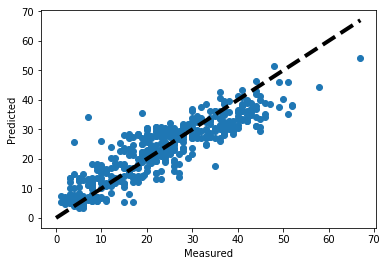

In [0]:
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline  

y_test = Y_val

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
# ax.set_ylim([0, y_test.max()])
ax.plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [0]:
model.predict(X_test)

array([33.085636, 26.087294, 44.588192, 15.418026], dtype=float32)

In [0]:
model.score(X_val, Y_val)

0.7920844884485115

## Some FastAI stuff

In [0]:
from fastai.tabular import *

In [0]:
xtr = pd.concat([X_train, Y_train], axis=1)

In [0]:
xval = pd.concat([X_val, Y_val], axis=1)

In [0]:
xtrain = pd.concat([xtr, xval])

In [0]:
xtrain = xtrain.sample(frac=1).reset_index(drop=True)

In [0]:
len(df)
procs = [FillMissing, Categorify, Normalize]
categorical_cols = ['b_type', 'plate_shape', 'new_plate_mat', 'nature', 'il_mat', 'bc_mat', 'glue']
dep_var = 'trauma'
cont_names = ['num_shot', 'il_num_layers', 'bc_num_layer', 'speed', 'plate_wt', 'thickness', 'ceramic_wt', 'plate_wt_before', 'plate_wt_after', 'il_wt', 'bc_wt', 'glue_wt', 
                'total_thickness', 'trauma', 'total_ad']

# test_df['trauma'] = 100

In [0]:
len(xtrain.columns), len(X_test.columns)

(158, 157)

In [0]:
xtrain.head(2), X_test.head(2)

(   b_diameter  b_length  ...  glue_Nolax A21  trauma
 0    0.923404  0.857143  ...               0    28.0
 1    0.923404  0.428571  ...               0    50.0
 
 [2 rows x 158 columns],
    b_diameter  b_length  ...  glue_Nolax Film A21.2007  glue_Nolax A21
 0    0.923404  0.535714  ...                         0               1
 1    0.923404  0.857143  ...                         0               1
 
 [2 rows x 157 columns])

In [0]:
np.random.seed(42)


path = '.'

data: DataBunch = TabularDataBunch.from_df(path, xtrain, dep_var='trauma', 
#                                            cat_names=categorical_cols, 
#                                            cont_names=cont_names, 
#                                            procs=procs,
                                           valid_idx=range(1050, len(df)), 
                                           test_df=X_test
                                           )
learn = tabular_learner(data, layers=[50, 10], metrics=mean_squared_error, path='.')
learn.loss_func = MSELossFlat()


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


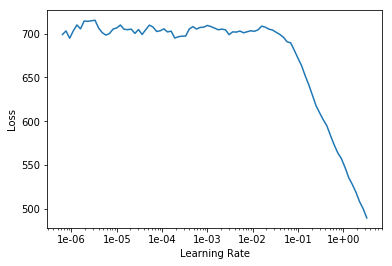

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(80, 4e-3)

epoch,train_loss,valid_loss,mean_squared_error,time
0,708.387939,742.822388,742.822388,00:00
1,709.760986,740.668640,740.668640,00:00
2,704.711304,739.161011,739.161011,00:00
3,701.643677,738.627991,738.628052,00:00
4,701.037537,737.089966,737.089966,00:00
5,698.517456,735.194946,735.194946,00:00
6,693.566833,732.302856,732.302856,00:00
7,688.152710,728.050354,728.050415,00:00
8,681.802734,721.506592,721.506470,00:00
9,675.993286,715.450867,715.450867,00:00


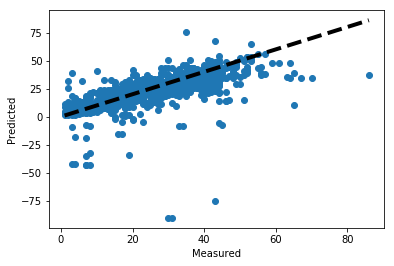

In [0]:
y = learn.get_preds()

y_test = y[1]
y_pred = y[0]

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
# ax.set_ylim([0,60])
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
preds

[tensor([[ 9.1435],
         [13.3129],
         [ 8.3278],
         [ 3.1236]]), tensor([0, 0, 0, 0])]

In [0]:
X_test

,b_diameter,b_length,speed,plate_wt,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_num_layers,il_wt,bc_num_layer,bc_wt,glue_wt,total_thickness,total_ad,b_type_FMJ,b_type_M43,b_type_M74,b_type_NATO BALL,b_type_APM2,b_type_Nato AP,b_type_B32,b_type_API BZ,b_type_LPS,b_type_SS 109,b_type_M1943 PS,b_type_A.K.Kirkee,b_type_MSC,b_type_SJHP,b_type_DM 111,b_type_Swiss AP,b_type_M193,b_type_X,b_type_MK 2 Ball,b_type_CP/Fej.,b_type_M855,b_type_MSC-Romania,b_type_RWS TUG,b_type_PPI,b_type_AK 47 (7N6),...,il_mat_E-Glass (0.8mm),il_mat_E-Glass (0.5mm),glue_Simson + Sikaflex 221 LV + Sikaflex 221 LV,glue_Simson,glue_Simson + Sikaflex 221 LV,glue_Sikaflex 221 LV,glue_X,glue_Sikaflex 221 LV + Simson,glue_Resin,glue_Simson + Nolax,glue_Nolax,glue_Sikaflex 221 LV + 3M 950,glue_Nolax + Sikaflex 221 LV,glue_Sikaflex 221 LV + Nolax,glue_Glue + Nolax + Sikaflex 221 LV,glue_3M Nolax S22.2031 + Sikaflex 221 LV,glue_Sikaflex 221 LV + 3m Film,glue_Sikaflex 221 LV + 3M Film,glue_Sikaflex 221 LV + Sikaflex 221 LV,glue_New Adhesive (Resinova),glue_Nolax S22.2031,glue_Nolax A21.2007 + Nolax S22.2031,glue_Sikaflex 221 LV + Nolax S22.2031,glue_A21.2007 (PE + PU) + Nolax S22.2031,glue_Nolax Film (250 gsm),glue_Nolax C44.8520,glue_Nolax C44.8520 + Nolax S22.2031,glue_Epoxy + Sikaflex 221 LV,glue_Nolax C44.6400,glue_Zenox,glue_Nolax C44.6400 + Nolax A21.2007,glue_Nolax A21.2007,glue_SA-1127,glue_Nolax C44.6400 + Zenox,glue_L&L AK-540,glue_Pantacol A21.2007,glue_Nolex film A21.2007(50gsm),glue_Nolax A21.2007Nolax A21.2007,glue_Nolax Film A21.2007,glue_Nolax A21
0,0.923404,0.535714,0.828402,0.250763,0.184211,0.000789,0.000677,0.000938,0.000000,0.000000,0.750000,0.000825,0.000439,0.488771,0.336207,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.923404,0.857143,0.857988,0.588748,0.473684,0.003270,0.001632,0.002202,0.000000,0.000000,0.712963,0.001119,0.000439,0.832232,0.629310,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.923404,0.535714,0.828402,0.436110,0.342105,0.001882,0.001201,0.001631,0.111111,0.039474,0.740741,0.000904,0.000439,0.792602,0.517241,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.923404,0.000000,0.626233,0.427388,0.289474,0.002091,0.001201,0.001607,0.111111,0.052632,0.555556,0.000904,0.000439,0.634082,0.439655,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## RandomForest Regressor

In [0]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 2000, random_state = 42)
# Train the model on training data
rf.fit(X_train, Y_train);

In [0]:
rf.score(X_val, Y_val)

0.8826794914296092

In [0]:
preds = rf.predict(X_test)

In [0]:
preds

array([31.738607, 27.227   , 53.405   , 15.8385  ])

In [0]:
predictions = rf.predict(X_val)

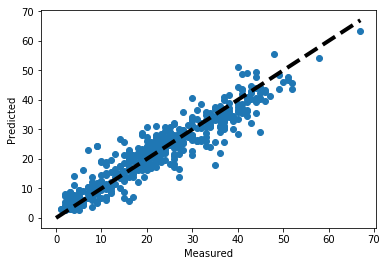

In [0]:
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline  

y_test = Y_val

fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
# ax.set_ylim([0, y_test.max()])
ax.plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [0]:
full_x = pd.concat([X_train, X_val])

In [0]:
full_y = pd.concat([Y_train, Y_val])

In [0]:
rf.fit(full_x, full_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [0]:
rf.predict(X_test)

array([32.6869 , 25.467  , 52.8355 , 16.34815])

In [0]:
rf.score(full_x, full_y)

0.9806309637793481

In [0]:
test_df

,test_standard,ammunition,b_diameter,b_length,b_type,speed,plate_shape,plate_wt,plate_mat,new_plate_mat,nature,thickness,ceramic_wt,plate_wt_before,plate_wt_after,il_mat,il_num_layers,il_wt,bc_num_layer,bc_wt,glue,glue_wt,total_thickness,total_ad
0,NaN,7.62,7.62,54.0,LPS,840.0,S.C.T.C.,1.15,B4C,B4C,Vest Dependent,3.5,0.415,1.10,1.15,X,0,0.00,81,0.575,Nolax A21,0.01,18.5,19.5
1,NaN,7.62,7.62,63.0,APM2,870.0,S.C.T.C.,2.70,B4C,B4C,Vest Dependent,9.0,1.720,2.65,2.70,X,0,0.00,77,0.780,Nolax A21,0.01,31.5,36.5
2,NaN,7.62,7.62,54.0,LPS,840.0,S.C.T.C.,2.00,SiC,SiC,Standalone,6.5,0.990,1.95,2.00,E-Glass (0.5mm),1,0.06,80,0.630,Nolax A21,0.01,30.0,30.0
3,NaN,7.62,7.62,39.0,A.K.Kirkee,635.0,S.C.T.C.,1.96,B4C,B4C,Vest Dependent,5.5,1.100,1.95,1.97,E-Glass (0.8mm),1,0.08,60,0.630,Nolax A21,0.01,24.0,25.5
